In [1]:
import pandas as pd
import numpy as np
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.base import clone
import matplotlib.pyplot as plt 

In [2]:
def gen_data():
    # Parameters
    n = 1000  # Number of individuals
    p = 50    # Number of covariates

    # Generate covariates for period 1
    x1 = np.random.randn(n, p)
    
    # Generate treatment which is binary and depends on a linear combination of x1 with a cutoff
    linear_combination = np.dot(x1, np.random.randn(p))
    d = (linear_combination + np.random.randn(n) > linear_combination.mean()).astype(int)

    # Generate covariates for period 2, dependent on x1 and d
    x2 = x1 + np.random.randn(n, p) +  np.outer(d, np.random.randn(p))
    
    # Generate errors which are independent
    e1 = np.random.randn(n)
    e2 = np.random.randn(n)


    def h(x, t):
        return t * np.dot(x, np.random.randn(p))

    # Treatment effect
    beta = 2.0

    # Generate outcomes
    y1 = h(x1, 1) + e1
    y2 = beta * d * 1 + h(x2, 2) + e2

    # Combine into a dataframe
    data_period1 = pd.DataFrame(x1, columns=[f'x{i+1}' for i in range(p)])
    data_period1['y'] = y1
    data_period1['d'] = d
    data_period1['t'] = 1

    data_period2 = pd.DataFrame(x2, columns=[f'x{i+1}' for i in range(p)])
    data_period2['y'] = y2
    data_period2['d'] = d
    data_period2['t'] = 2

    data = pd.concat([data_period1, data_period2], ignore_index=True)
    
    return data

# Generate the data
data = gen_data()

print(data[['d','t']].describe())
print(data[['d','t']][data['t']==1].describe())
print(data[['d','t']][data['t']==2].describe())

                 d            t
count  2000.000000  2000.000000
mean      0.509000     1.500000
std       0.500044     0.500125
min       0.000000     1.000000
25%       0.000000     1.000000
50%       1.000000     1.500000
75%       1.000000     2.000000
max       1.000000     2.000000
                 d       t
count  1000.000000  1000.0
mean      0.509000     1.0
std       0.500169     0.0
min       0.000000     1.0
25%       0.000000     1.0
50%       1.000000     1.0
75%       1.000000     1.0
max       1.000000     1.0
                 d       t
count  1000.000000  1000.0
mean      0.509000     2.0
std       0.500169     0.0
min       0.000000     2.0
25%       0.000000     2.0
50%       1.000000     2.0
75%       1.000000     2.0
max       1.000000     2.0


In [3]:
def regular_estimate(data):
    # Define outcome, treatment, and covariates
    
    n = data.shape[0]
    p = data.shape[1] -3
    
    y = data['y']
    d = data['d']
    t = data['t']

    # Define d*(t==2)
    dt = (d * (t == 2)).astype(float)
    dt.name = 'dt'  # properly name the series

    x = data[[f'x{i+1}' for i in range(p)]]

    # Double Machine Learning
    #learner = RandomForestRegressor(n_estimators=20)#n_estimators=50)#, max_features=10, max_depth=5, min_samples_leaf=5)
    learner = Lasso()
    ml_m = clone(learner)
    ml_l = clone(learner)

    #Note: ml_l.fit(x, y) ... ml_m.fit(x, d)
    dml_data = dml.DoubleMLData(pd.concat([x.copy(), dt.copy(), y.copy()], axis=1), y_col='y', d_cols='dt')
    dml_plr = dml.DoubleMLPLR(dml_data,  ml_m=ml_m, ml_l=ml_l)
    dml_plr.fit()
    return dml_plr.coef[0]
    
    
def just_pre_treatment(data):
    
    n = data.shape[0]
    p = data.shape[1] -3
    
    # Assuming `data` is your DataFrame
    data_period1 = data[data['t'] == 1].copy()
    data_period2 = data[data['t'] == 2].copy()

    # Identifying columns that start with 'x'
    x_columns = [col for col in data_period1.columns if col.startswith('x')]

    # Carry forward period 1 x values to period 2 and ignore the indices
    data_period2_for_estimation = data_period2.copy()
    data_period2_for_estimation[x_columns] = data_period1[x_columns].values

    # Combine the modified period 2 with period 1 data
    data_for_estimation = pd.concat([data_period1, data_period2_for_estimation], ignore_index=True)
    
    y = data_for_estimation['y']
    d = data_for_estimation['d']
    t = data_for_estimation['t']

    # Define d*(t==2) again
    dt = (d * (t == 2)).astype(float)
    dt.name = 'dt'  # properly name the series

    x = data_for_estimation[[col for col in data_for_estimation.columns if col.startswith('x')]]
    
    learner = Lasso()
    ml_g = clone(learner)
    ml_m = clone(learner)
    ml_l = clone(learner)
    
    # Double Machine Learning
    dml_data = dml.DoubleMLData(pd.concat([x.copy(), dt.copy(), y.copy()], axis=1), y_col='y', d_cols='dt')
    dml_plr = dml.DoubleMLPLR(dml_data, ml_m=ml_m, ml_l=ml_l)
    dml_plr.fit()
    return dml_plr.coef[0]


just_pre_results = []
regular_results = []

for i in range(1000):
    data = gen_data()
    regular_coef = regular_estimate(data) 
    pre_treat_coef = just_pre_treatment(data)
    just_pre_results.append(pre_treat_coef)
    regular_results.append( regular_coef )

Just Pre-Period Results: Mean = 1.7753666358941913, Std Dev = 13.002867464444648
Double ML Results: Mean = 0.42076744152365453, Std Dev = 1.7242677857185478


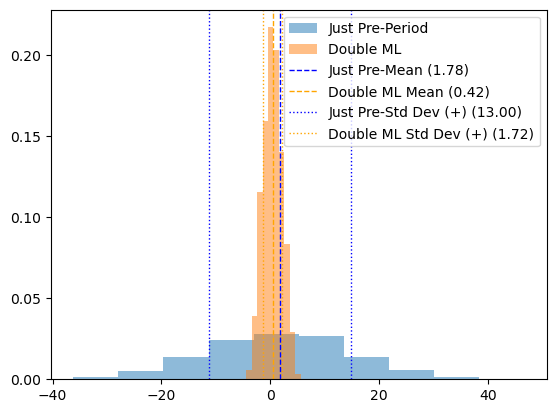

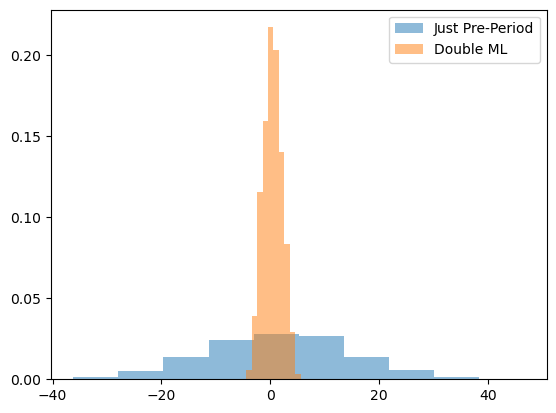

In [4]:

# Calculate means and standard deviations
mean_just_pre_results = np.mean(just_pre_results)
std_just_pre_results = np.std(just_pre_results)

mean_regular_results = np.mean(regular_results)
std_regular_results = np.std(regular_results)

# Print the mean and standard deviation values
print(f"Just Pre-Period Results: Mean = {mean_just_pre_results}, Std Dev = {std_just_pre_results}")
print(f"Double ML Results: Mean = {mean_regular_results}, Std Dev = {std_regular_results}")

# Plot the histograms
plt.hist(just_pre_results, label='Just Pre-Period', density=True, alpha=0.5)
plt.hist(regular_results, label='Double ML', density=True, alpha=0.5)

# Plot the means
plt.axvline(mean_just_pre_results, color='blue', linestyle='dashed', linewidth=1, label=f'Just Pre-Mean ({mean_just_pre_results:.2f})')
plt.axvline(mean_regular_results, color='orange', linestyle='dashed', linewidth=1, label=f'Double ML Mean ({mean_regular_results:.2f})')

# Plot the standard deviations
plt.axvline(mean_just_pre_results + std_just_pre_results, color='blue', linestyle='dotted', linewidth=1, label=f'Just Pre-Std Dev (+) ({std_just_pre_results:.2f})')
plt.axvline(mean_just_pre_results - std_just_pre_results, color='blue', linestyle='dotted', linewidth=1)

plt.axvline(mean_regular_results + std_regular_results, color='orange', linestyle='dotted', linewidth=1, label=f'Double ML Std Dev (+) ({std_regular_results:.2f})')
plt.axvline(mean_regular_results - std_regular_results, color='orange', linestyle='dotted', linewidth=1)

# Adding legend
plt.legend()
plt.show()
plt.hist(just_pre_results, label='Just Pre-Period',density=True,alpha=.5)
plt.hist(regular_results, label='Double ML',density=True,alpha=.5)
plt.legend()
plt.show()